In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

#from torchvision.ops import complete_box_iou_loss, distance_box_iou_loss

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_backbone_big/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('OPTIM BED final test: train with all objects, eval with maximum 3')

# Folders

In [4]:
ds_dir = '../../ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['.ipynb_checkpoints', 'labels', 'images']


# Config

In [5]:
CLASSES = ["smoke", "fire"]

#IMG_DIM = {'W':88, 'H':88} # (W, H)
IMG_DIM = {'W':224, 'H':224} # (W, H)

SX = 7
SY = 7
B = 2 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [6]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

        if c == 0:
            class_name = "smoke"
        elif c == 1:
            class_name = "fire"
        else:
            print("Wrong class")
            raise SystemExit("Wrong class in mAP")
        plt.plot(recalls, precisions, 'b')
        plt.scatter(recalls, precisions, color='b')
        plt.fill_between(recalls, precisions, facecolor='b', alpha=0.1)
        plt.title("Precision-Recall Curve")
        plt.ylim([0,1])
        plt.xlim([0,1])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.grid()
        plt.savefig(log_path + class_name + "_pre_rec_curve.png")
        plt.close()

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    loop = tqdm(loader, desc='Get Boxes', leave=True)
    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    #for batch_idx, (imgs, labels) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loop):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred, as bboxes have Conf = 1 and the rest are 0
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:12]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, class_0, class_1]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:7].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    # If SOFTMAX is used, there is no need to multiply conf * class_prob
    # scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    # scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    scores = boxes[..., 4:5]
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# DFire

In [7]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 num_imgs,
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_imgs = num_imgs
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1)
                                ])

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )

        # Limit to n examples
        if self.num_imgs is not None:
            random.seed(123)
            random.shuffle(self.labels_list)       
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list[:self.num_imgs])
            self.num_samples = self.images.shape[0]
        else:
            self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)        
            self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()

                    # Restrict to max_obj boxes per sample
                    if len(lines) > self.max_obj:
                        more_than_x += 1
                        continue
                        
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # smoke
                            if class_id == 0:
                                one_labels.append(0)
                            # fire
                            elif class_id == 1:
                                one_labels.append(1)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire Removed due to overlapping: {overlapping_rem}')
        print(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFire Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image'] 
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] 
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.0)
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# DFS

In [8]:
dfs_base_dir = '../../ds2fire/dfs_xml/'
dfs_images_dir = dfs_base_dir + 'images/'
dfs_labels_dir = dfs_base_dir + 'labels/'


# Get all txt file paths in path_annot and sort them
dfs_xml_files = sorted(
    [
        os.path.join(dfs_labels_dir, file_name)
        for file_name in os.listdir(dfs_labels_dir)
        if file_name.endswith(".xml")
    ]
)

dfs_len = len(dfs_xml_files)
dfs_train_elements = int(dfs_len*0.8)
dfs_test_elements = dfs_len - dfs_train_elements

random.seed(123)
random.shuffle(dfs_xml_files)
dfs_train_list = dfs_xml_files[:dfs_train_elements]
dfs_test_list = dfs_xml_files[dfs_train_elements:]

print(f'DFS number of samples: {dfs_len}')
print(f'DFS train samples: {len(dfs_train_list)}')
print(f'DFS test samples: {len(dfs_test_list)}')

DFS number of samples: 9462
DFS train samples: 7569
DFS test samples: 1893


In [9]:
class DFSDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - max_obj:          maximum number of objects in the picture
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, labels_list, 
                 SX, SY, C, max_obj,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.labels_list = labels_list
        self.SX = SX
        self.SY = SY
        self.C = C
        self.max_obj = max_obj
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                ])

        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        more_than_x = 0
        
        
        for xml_file in labels_list:
#             fname = Path(xml_file).stem
#             image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            image_name = root.find("filename").text
            image_path = os.path.join(self.img_dir, image_name)
            #print(image_name, image_path)
            
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                overlapping_object = 0
                more_than_x_in = 0

                label_mtx = np.zeros((self.SY, self.SX))

                size = root.find("size")
                img_w = float(size.find("width").text)
                img_h = float(size.find("height").text)

                one_bboxes = []
                one_labels = []

                for obj in root.iter("object"):
                    class_name = obj.find("name").text
                    if class_name == 'smoke':
                        class_id = 0
                        more_than_x_in += 1
                    elif class_name == 'fire':
                        class_id = 1
                        more_than_x_in += 1
                    else:
                        continue 
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)/img_w
                    ymin = float(bbox.find("ymin").text)/img_h
                    xmax = float(bbox.find("xmax").text)/img_w
                    ymax = float(bbox.find("ymax").text)/img_h

                    box = self.__bbox_check__([xmin, ymin, xmax, ymax])
                    #print(f'Class: {class_name} - Class_id: {class_id}. Coords: x={x}, y={y}, w={w}, h={h}')

                    x, y, w, h = box[0], box[1], box[2], box[3]
                    i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                    if label_mtx[i, j] == 1:
                        overlapping_object = 1
                        overlapping_rem += 1
                        break
                    else:
                        label_mtx[i, j] = 1
                        one_bboxes.append([x, y, w, h])
                        # smoke
                        if class_id == 0:
                            one_labels.append(0)
                        # fire
                        elif class_id == 1:
                            one_labels.append(1)
                        else:
                            print(f'File {label} errored in cell {i, j}') 
                
                if more_than_x_in > self.max_obj:
                    more_than_x += 1
                    continue
                
                if (overlapping_object == 0) and (more_than_x_in < (self.max_obj+1)):
                    # Padding to SX*SY labels and bounding boxes, so you can store tensors
                    # Label -1 indicates no box
                    for idx in range(self.SX*self.SY - len(one_labels)):
                        one_bboxes.append([0, 0, 0, 0])
                        one_labels.append(-1)
                    # print(f'\nBboxes and Labels of image {image_path}')
                    # print("Bboxes")
                    # for box in one_bboxes:
                    #     print(box)
                    # print("Labels")
                    # for label in one_labels:
                    #     print(label)
                    bboxes.append(one_bboxes)
                    labels.append(one_labels)
                    images.append(image_path)

        print(f'DFS Removed wrong images: {wrong_imgs}')
        print(f'DFS Removed due to overlapping: {overlapping_rem}')
        print(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')
        logger.info(f'DFS Removed wrong images: {wrong_imgs}')
        logger.info(f'DFS Removed due to overlapping: {overlapping_rem}')
        logger.info(f'DFS Removed due to more than {self.max_obj}: {more_than_x}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels


 
    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] 
                # img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                # img = (img / 255.) 
                # img = torch.tensor(img, dtype=torch.float32)
                # img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [10]:
# view_dir = 'dfire4ex/train/'

# view_train_imgs = view_dir + 'images/'
# view_train_labels = view_dir + 'labels/'

In [11]:
VIEW_BATCH_SIZE = 32
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 7
VIEW_C = 2
VIEW_B = 1
VIEW_MAX_OBJ = 10

VIEW_IMG_W = 224
VIEW_IMG_H = 224

# Data Aug Function

In [12]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                                  width= int(1.4*VIEW_IMG_W),
                                  erosion_rate=0.3,
                                  p=0.3),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
        ], p=0.9),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=16*16, 
                                min_visibility=0.1, 
                                label_fields=['class_labels']))

# DFS Dataset

In [13]:
logger.info('\nBefore View Dataset Examples')

view_dfs_dataset = DFSDataset(img_h = VIEW_IMG_H,
                              img_w = VIEW_IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = VIEW_S,
                              SY = VIEW_S,
                              C = VIEW_C,
                              max_obj = VIEW_MAX_OBJ,
                              transform=view_transform)

DFS Removed wrong images: 0
DFS Removed due to overlapping: 58
DFS Removed due to more than 10: 2


# View Loader

In [14]:
view_loader = DataLoader(dataset=view_dfs_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

# Utils to Plot

In [15]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'smoke', 1: 'fire'}
    colors = {'smoke': (0,255,255), 'fire': (255,255,0)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()       

    for i,(xc,yc,w,h,score,smoke,fire) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.uint8).tolist()
        if smoke == 1:
            cls_id = 0
        elif fire == 1:
            cls_id = 1
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

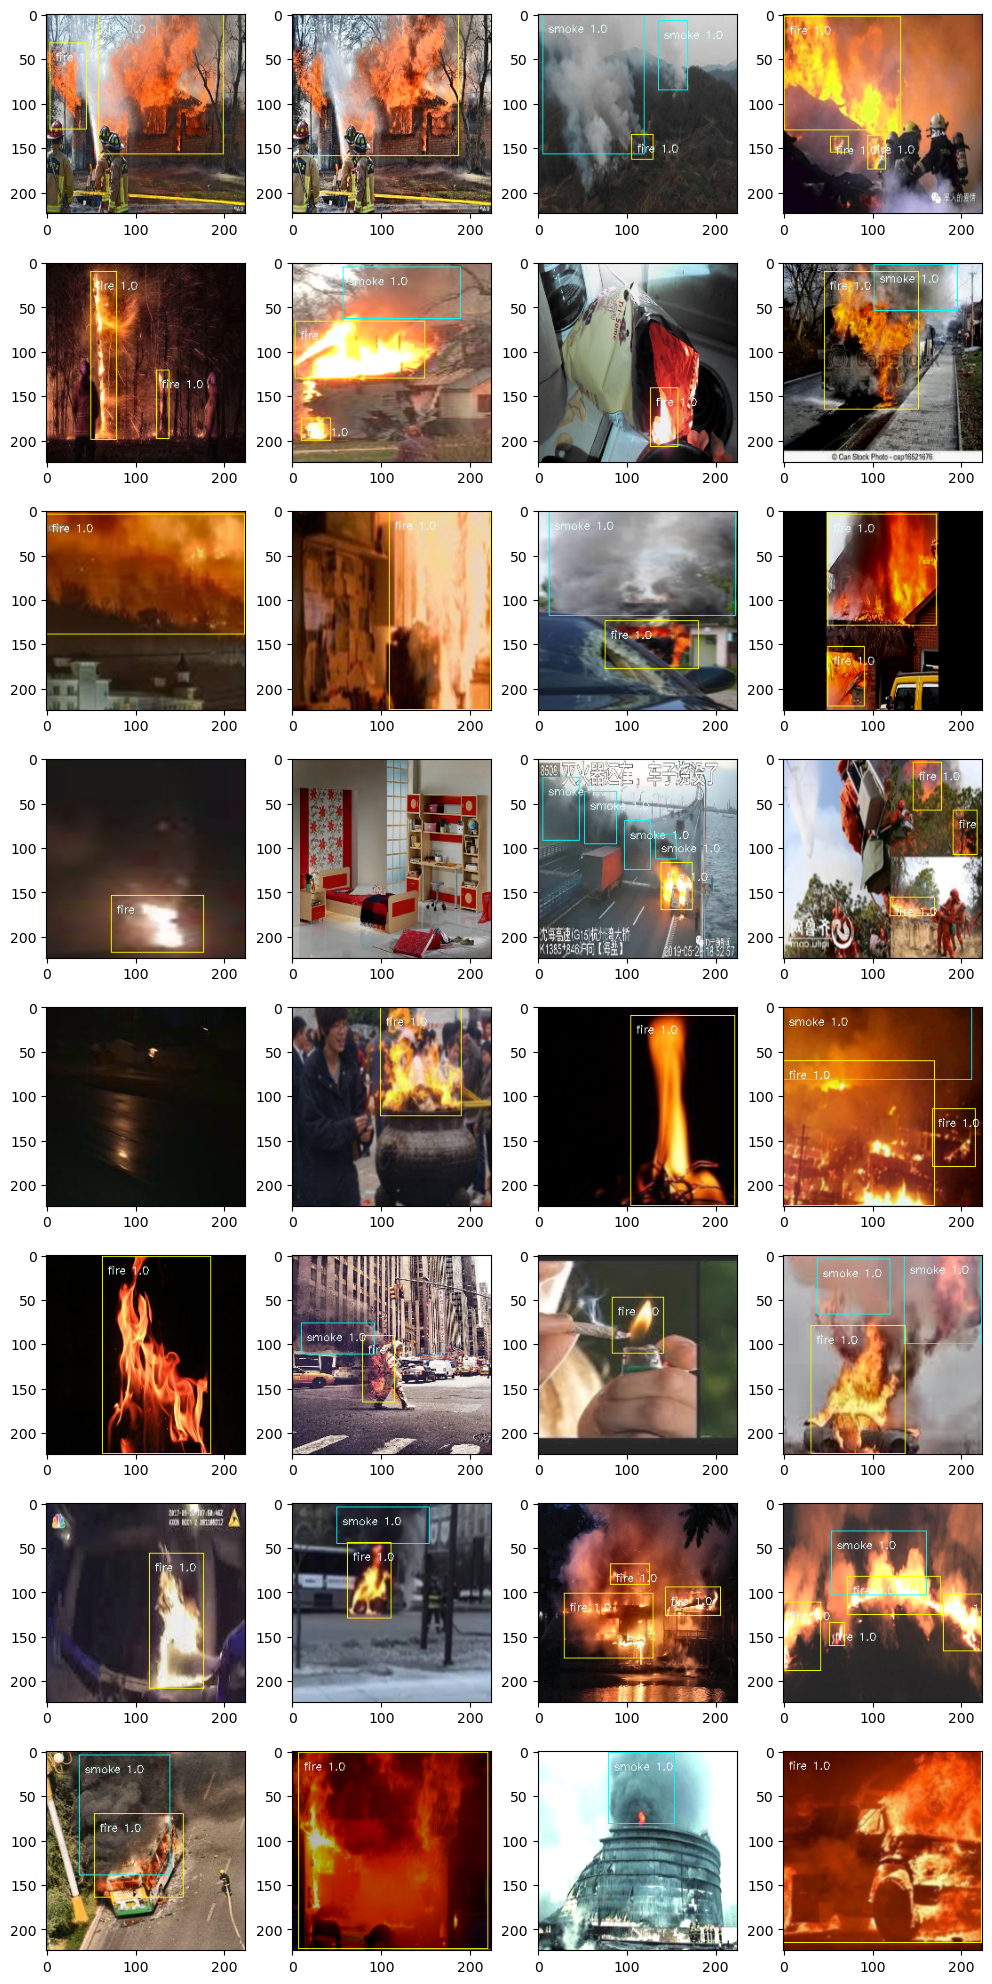

In [16]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):
for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(8,4, figsize=(10, 20))

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(8, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 31):
            break
    #if (idx == 1):
    plt.tight_layout()
    plt.show()
    break

# Classifier Model

In [17]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 128
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        ############## Recortar aquí. Quizá solo 1 Linear
        ############## Recortar en el backbone
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.last_channels, out_features=1),
            # nn.ReLU(),
            # nn.Linear(in_features=64, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=self.last_channels, out_features=1),
            # nn.ReLU(),
            # nn.Linear(in_features=64, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            #nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            
            ############## Quizá quitar este kernel
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(128, affine=False),
            nn.ReLU(),
            nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(self.last_channels, affine=False),
            nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# PRETRAINED OPTIM BED

In [18]:
class PRETRAINED_OPTIM_BED(nn.Module):
    def __init__(self, base_model, num_classes, S, B, in_channels=3):
        super(PRETRAINED_OPTIM_BED, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.base_model = nn.Sequential(*list(base_model.children())[:-3])
        self.head_model = self.__create_head__()
        
    def __create_head__(self):
        BED_head = nn.Sequential(            
            # CNNBlock Out
            nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),            
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.5),
            
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_head 

    # TODO: initizalize only head layers
    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_in',
    #                 nonlinearity='relu'
    #             )
    #             if m.bias is not None:
    #                     nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    # [xc1, yc1, w1, h1, conf1, xc2, yc2, w2, h2, conf2, smoke, fire]
    # [0 ................. 4,    5 ................ 9      10    11 ]
    
    def forward(self, x):
        x = self.base_model(x)
        x_out = self.head_model(x)
        x = x_out.permute(0, 2, 3, 1)
        if self.B == 1:
            class_softmax = torch.softmax(x[..., 5:7], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)  
        else:
            class_softmax = torch.softmax(x[..., 10:12], dim=-1)
            x = torch.cat((torch.sigmoid(x[..., 0:10]), class_softmax), dim=-1)
        return x 

# Yolo Loss 2BB

In [19]:
class YoloLossMSE_2BBox(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE_2BBox, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        self.lambda_conf = 1.5
              
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        #predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)
        assert predictions.shape == (BATCH_SIZE, self.SY, self.SX, self.B*5 + self.C) 
        assert ground_truth.shape == (BATCH_SIZE, self.SY, self.SX, 5 + self.C) 
        
        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5] == 1
        pred_box1 = exists_box*predictions[..., 0:4]
        pred_box2 = exists_box*predictions[..., 5:9]
        target_box = exists_box*ground_truth[..., :4]

        # =========================== #
        #            IOU              #
        # =========================== #
        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou1 = iou_tensor(boxes_preds=pred_box1, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 1\n{iou1}')
        iou2 = iou_tensor(boxes_preds=pred_box2, 
                   boxes_labels=target_box,
                   box_format="midpoint")
        #print(f'IOU 2\n{iou2}')
        ious = torch.cat([iou1, iou2], dim=-1)
        #print(f'IOUs\n{ious}')
        
        iou_maxes, best_boxes = torch.max(ious, keepdim=True, dim=-1)
        pred_boxes = best_boxes*pred_box2[..., :4]+(1-best_boxes)*pred_box1[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(pred_boxes[..., :2],
                           target_box[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign 
        wh_loss = self.mse(torch.sign(pred_boxes[..., 2:4])*torch.sqrt(torch.abs(pred_boxes[..., 2:4])+1e-6),
                           torch.sqrt(target_box[..., 2:4]))
        #print(f'WH Loss {wh_loss:.6f}')
        self.last_box_wh = wh_loss.item()

        # =================== #
        #   Confidence Loss   #
        # =================== #
        conf_pred_box = exists_box*( best_boxes*predictions[..., 9:10] + (1-best_boxes) * predictions[..., 4:5])
        #print(f'Conf pred boxes \n {conf_pred_box}')
        # conf_loss = self.mse(conf_pred_box,
        #                      iou_maxes)
        conf_loss = self.mse(conf_pred_box,
                             exists_box*ground_truth[..., 4:5])
        #print(f'Conf loss {conf_loss:.6f}')
        self.last_obj = conf_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_box1 = self.mse((~exists_box)*predictions[..., 4:5],
                              (~exists_box)*ground_truth[..., 4:5])
        noobj_box2 = self.mse((~exists_box)*predictions[..., 9:10],
                              (~exists_box)*ground_truth[..., 4:5])    
        noobj_loss = noobj_box1 + noobj_box2
        #print(f'No Obj loss {noobj_loss:.6f}')
        self.last_noobj = noobj_loss.item()

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 10:12],
                              exists_box*ground_truth[..., 5:7]) 
        #print(f'Class Loss {class_loss:.6f}')
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + self.lambda_conf*conf_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss

    def get_last_losses(self):     
        return (
            self.lambda_coord*self.last_box_xy,
            self.lambda_coord*self.last_box_wh,
            self.lambda_conf*self.last_obj,
            self.lambda_noobj*self.last_noobj,
            self.last_class
            )

# Train Loop Function

In [20]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, loss_l1_lambda, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)

        l1_lambda = loss_l1_lambda  # hyperparameter for L1 regularization
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        train_loss = train_loss + l1_lambda * l1_norm
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    #print("\nTRAIN losses")
    logger.info("\nTRAIN losses")
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)

# Validation Loop Function

In [21]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)

        
        # MSE Loss
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    #print("\nVAL losses")
    logger.info("\nVAL losses")
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))

    logger.info("Total Loss".ljust(12) + "|" + 
                  "Box Loss".ljust(12) + "|" + 
                  "Conf Loss".ljust(12) + "|" + 
                  "No Obj Loss".ljust(12) + "|" + 
                  "Class Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12) + " " + 
                  "------------".ljust(12))
    logger.info(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
                  f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)

# Hyperparameters and Config

In [22]:
''' ============================
    Hyperparameters and More
============================ '''

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 90
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = log_path + "bed_best_2BB_mAP.pt"
PRETRAINED = True

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

TRAIN_MAX_OBJ = 3
TEST_MAX_OBJ = 3

LOSS_FN = "MSE"
L1_LAMBDA = 0.001 # Less regularization. From 0.001 to 0.0001

LOG_FILE = "log_file.xlsx"

IOU_mAP_THRES = 0.5
IOU_NMS_THRES = 0.5
THRESHOLD = 0.2

''' ============================
    Configuration
============================ '''
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

epochs_plot = []

# MODEL Setup

In [23]:
if IMG_W == 88:
    print("Using Tinyssimo 88x88")
    logger.info("Using Tinyssimo 88x88")
    model = Tinyssimo_fixed_88x88_BatchNorm(num_classes=C).to(DEVICE)
elif IMG_W == 224:
    if PRETRAINED == True:
        print("Using Pretrained OPTIM BED 224x224")
        logger.info("Using Pretrained OPTIM BED 224x224")
        
        base_model = BED_CLASSIFIER(num_classes=C)
        model_file = '../classifier/metrics_BIG_1/' + 'last_bed_classifier.pt'
        checkpoint = torch.load(model_file, map_location=torch.device(DEVICE))
        #base_model.load_state_dict(checkpoint['model_state_dict'])
        base_model.load_state_dict(checkpoint)
        model = PRETRAINED_OPTIM_BED(base_model=base_model, 
                                     num_classes=C, 
                                     S=SX, 
                                     B=B, 
                                     in_channels=3).to(DEVICE)
    else:
        print("Use Pretrained in this script")
        logger.info("Use Pretrained in this script")
        raise SystemExit("Use Pretrained in this script")        
        
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test.shape}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test.shape}')
logger.info(f'BED Model Arquitecture\n{model}')   

optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.1, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using Pretrained OPTIM BED 224x224
Model shape is torch.Size([4, 7, 7, 12])
BED Model Arquitecture
PRETRAINED_OPTIM_BED(
  (base_model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (2): ReLU()
      (3): Dropout2d(p=0.3, inplace=False)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (7): ReLU()
      (8): Dropout2d(p=0.3, inplace=False)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
      (1

# Loss Function Setup

In [24]:
if B == 1:
    print(f'Using YoloLossMSE')
    logger.info(f'Using YoloLossMSE')
    loss_fn = YoloLossMSE(SX=SX, 
                          SY=SY, 
                          B=B, 
                          C=C)
elif B == 2:
    if LOSS_FN == "MSE":
        print(f'Using YoloLossMSE_2BBox')
        logger.info(f'Using YoloLossMSE_2BBox')
        loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    elif LOSS_FN == "DIOU":
        print(f'Using YoloLossDIOU_2BBox')
        logger.info(f'Using YoloLossDIOU_2BBox')
        loss_fn =YoloLossCIOU_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    else:
        raise SystemExit("Wrong Loss Function")
    print(f'L1 lambda: {L1_LAMBDA}')
    logger.info(f'L1 lambda: {L1_LAMBDA}')
else:
    print(f"Wrong B bounding boxes configuration: {B}")
    logger.info(f"Wrong B bounding boxes configuration: {B}")
    raise SystemExit("Wrong B bounding boxes configuration")

Using YoloLossMSE_2BBox
L1 lambda: 0.001


# Dataset and DataLoaders

In [25]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    # If boxes are to close, it can remove some because they fall inside same cell
    A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                              width= int(1.4*IMG_W),
                              erosion_rate=0.3,
                              p=0.3),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.4),
        A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        A.Blur(blur_limit=(3,3), p=0.3),
        A.CLAHE(clip_limit=2.0, p=0.3),
    ], p=0.9),
        # Shifting, scaling and rotation could dive 2 bbox inside same grid...
        #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', 
                            min_area=16*16, 
                            min_visibility=0.1, 
                            label_fields=['class_labels']))
# TRAIN
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_imgs = None,
                             SX = SX,
                             SY = SY,
                             C = C,
                             max_obj = TRAIN_MAX_OBJ,
                             transform=train_transform)

print("TRAIN DFS dataset")
logger.info("TRAIN DFS dataset")
train_dfs_dataset = DFSDataset(img_h = IMG_H,
                               img_w = IMG_W,
                               img_dir = dfs_images_dir,
                               labels_list = dfs_train_list,
                               SX = SX,
                               SY = SY,
                               C = C,
                               max_obj = TRAIN_MAX_OBJ,
                               transform=train_transform)

print("Concatenate Train DFire and DFS datasets")
logger.info("Concatenate Train DFire and DFS datasets")
full_train_ds = torch.utils.data.ConcatDataset((train_dataset, train_dfs_dataset))
print(f'Train dataset len: {len(full_train_ds)}')
logger.info(f'Train dataset len: {len(full_train_ds)}')


# VALIDATION
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
eval_dataset = DFireDataset(img_h = IMG_H,
                            img_w = IMG_W,
                            img_dir = EVAL_IMG_DIR,
                            label_dir = EVAL_LABEL_DIR,
                            num_imgs = None,
                            SX = SX,
                            SY = SY,
                            C = C,
                            max_obj = TEST_MAX_OBJ,
                            transform=val_transform)
print("TEST DFS dataset")
logger.info("TEST DFS dataset")
test_dfs_dataset = DFSDataset(img_h = IMG_H,
                              img_w = IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = SX,
                              SY = SY,
                              C = C,
                              max_obj = TEST_MAX_OBJ,
                              transform=val_transform)

print("Concatenate Test DFire and DFS datasets")
logger.info("Concatenate Test DFire and DFS datasets")
full_test_ds = torch.utils.data.ConcatDataset((eval_dataset, test_dfs_dataset))
print(f'Test dataset len: {len(full_test_ds)}')
logger.info(f'Test dataset len: {len(full_test_ds)}')


# LOADERS
train_loader = DataLoader(dataset=full_train_ds,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

eval_loader = DataLoader(dataset=full_test_ds,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         shuffle=False,
                         drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire Removed due to overlapping: 546
DFire Removed due to more than 3: 1764
TRAIN DFS dataset
DFS Removed wrong images: 0
DFS Removed due to overlapping: 288
DFS Removed due to more than 3: 1231
Concatenate Train DFire and DFS datasets
Train dataset len: 21112

TEST DFire dataset
DFire Removed wrong images: 0
DFire Removed due to overlapping: 118
DFire Removed due to more than 3: 445
TEST DFS dataset
DFS Removed wrong images: 0
DFS Removed due to overlapping: 58
DFS Removed due to more than 3: 277
Concatenate Test DFire and DFS datasets
Test dataset len: 5330


# Main Function

In [26]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    print(f'\nConfidence Threshold: {THRESHOLD}')
    print(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    print(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    print(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    print(f'Max Test Obj per image: {TEST_MAX_OBJ}\n')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')
    logger.info(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    logger.info(f'\nConfidence Threshold: {THRESHOLD}')
    logger.info(f'IOU mAP Threshold: {IOU_mAP_THRES}')
    logger.info(f'IOU NMS Threshold: {IOU_NMS_THRES}\n')
    logger.info(f'Max Train Obj per image: {TRAIN_MAX_OBJ}')
    logger.info(f'Max Test Obj per image: {TEST_MAX_OBJ}\n')

    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_mAP = -1

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if PRETRAINED == True:
        print("Using a Pretrained Model")
        logger.info("Using a Pretrained Model")        
    elif LOAD_MODEL == False:
        print("Initializing Weights")
        logger.info("Initializing Weights")
        model._initialize_weights()
    else:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    #for epoch in range(EPOCHS):
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=model, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               loss_l1_lambda=L1_LAMBDA,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        

        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=model,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_NMS_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_mAP_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec:.3f}")
            logger.info(f"\nTrain mAP: {mean_avg_prec:.3f}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=model,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 5 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=model,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_NMS_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_mAP_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec:.3f}")
                logger.info(f"\nValidation mAP: {mean_avg_prec:.3f}")

                epochs_plot.append(epoch)
                plt.plot(epochs_plot, val_mAP, 'b', label="Val mAP")
                plt.scatter(epochs_plot, val_mAP, color='b')
                plt.title("Val mAP:@.50")
                plt.ylim([0,1])
                plt.xlabel("Epochs")
                plt.ylabel("mAP:@.50")
                plt.legend()
                plt.grid()
                plt.savefig(log_path + "Temp_bed_mAP.png")
                plt.close()

                if best_mAP < mean_avg_prec:
                    best_mAP = mean_avg_prec
                    print(f"\nSaving model with new best val mAP: {best_mAP:.3f}")
                    logger.info(f"\nSaving model with new best val mAP: {best_mAP:.3f}") 
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict()}, log_path + 'bed_best_2BB_mAP.pt') 

        if ( (epoch+1) % 5 ) == 0:
            torch.save(model.state_dict(), log_path + 'bed_2BB_5epoch.pt')
            
        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save(model.state_dict(), log_path + 'best_2BB.pt')     
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_2BB.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')

# Main Execute

In [27]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    #print(torch.cuda.is_available())
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
SX: 7
SY: 7
B: 2
C: 2

Confidence Threshold: 0.2
IOU mAP Threshold: 0.5
IOU NMS Threshold: 0.5

Max Train Obj per image: 3
Max Test Obj per image: 3


***Start Training: 22:40:58

Using a Pretrained Model

=== EPOCH 0/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:14<00:00,  2.45it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
502.516     |58.109      |33.948      |359.623     |16.072      



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
319.695     |68.945      |45.668      |195.919     |9.163       

Saving model with new best validation loss: 319.695

=== EPOCH 1/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:27<00:00,  2.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
217.296     |51.743      |55.045      |68.686      |9.564       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
168.172     |61.320      |64.967      |33.622      |8.263       

Saving model with new best validation loss: 168.172

=== EPOCH 2/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:26<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
166.045     |48.580      |62.751      |18.352      |8.630       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.86it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
147.755     |57.241      |68.115      |14.708      |7.690       

Saving model with new best validation loss: 147.755

=== EPOCH 3/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:25<00:00,  2.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
152.278     |45.379      |63.917      |10.971      |7.797       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.16it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
138.370     |52.335      |68.238      |10.298      |7.499       

Saving model with new best validation loss: 138.370

=== EPOCH 4/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:22<00:00,  2.31it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
145.158     |43.728      |63.963      |8.702       |6.988       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
133.887     |49.978      |66.540      |9.393       |7.977       


mAP:@.5: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]



Validation mAP: 0.032

Saving model with new best val mAP: 0.032

Saving model with new best validation loss: 133.887

=== EPOCH 5/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:24<00:00,  2.27it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
140.272     |42.302      |63.229      |7.835       |6.736       



Validating: 100%|██████████| 83/83 [00:31<00:00,  2.68it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
129.898     |48.660      |67.053      |7.437       |6.747       

Saving model with new best validation loss: 129.898

=== EPOCH 6/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:13<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
137.202     |41.583      |62.530      |7.418       |6.641       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.94it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
128.379     |49.083      |65.480      |7.316       |6.500       

Saving model with new best validation loss: 128.379

=== EPOCH 7/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:17<00:00,  2.40it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
134.612     |41.394      |61.637      |7.423       |6.017       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.95it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
125.067     |47.967      |63.127      |7.862       |6.112       

Saving model with new best validation loss: 125.067

=== EPOCH 8/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:19<00:00,  2.35it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
132.555     |41.044      |60.656      |7.318       |6.100       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
123.186     |47.228      |61.953      |7.939       |6.067       

Saving model with new best validation loss: 123.186

=== EPOCH 9/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:14<00:00,  2.44it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
130.572     |40.844      |59.317      |7.607       |5.878       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.23it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.444     |46.787      |62.246      |7.057       |6.354       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]



Validation mAP: 0.084

Saving model with new best val mAP: 0.084

Saving model with new best validation loss: 122.444

=== EPOCH 10/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:18<00:00,  2.38it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
128.554     |40.313      |58.561      |7.531       |5.712       



Validating: 100%|██████████| 83/83 [00:29<00:00,  2.86it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
122.829     |46.593      |62.759      |6.690       |6.787       

=== EPOCH 11/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:19<00:00,  2.36it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
127.578     |40.559      |57.300      |7.912       |5.666       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
119.388     |45.567      |59.271      |8.075       |6.475       

Saving model with new best validation loss: 119.388

=== EPOCH 12/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:11<00:00,  2.49it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
126.288     |39.952      |56.880      |7.817       |5.765       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.29it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.959     |44.704      |58.519      |8.359       |5.377       

Saving model with new best validation loss: 116.959

=== EPOCH 13/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:13<00:00,  2.47it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.662     |39.683      |55.939      |7.991       |5.370       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.15it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.318     |44.194      |59.662      |6.790       |5.673       

Saving model with new best validation loss: 116.318

=== EPOCH 14/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:21<00:00,  2.33it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
124.270     |39.422      |55.865      |8.034       |5.529       



mAP:@.5: 100%|██████████| 2/2 [00:20<00:00, 10.34s/it]



Train mAP: 0.122


Validating: 100%|██████████| 83/83 [00:23<00:00,  3.47it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.793     |44.249      |60.420      |6.242       |5.882       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.34s/it]



Validation mAP: 0.106

Saving model with new best val mAP: 0.106

=== EPOCH 15/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:13<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
123.214     |39.336      |55.067      |8.146       |5.410       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.048     |43.432      |56.621      |7.621       |5.375       

Saving model with new best validation loss: 113.048

=== EPOCH 16/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:16<00:00,  2.41it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.689     |38.914      |54.169      |8.401       |5.129       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.24it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.421     |43.249      |53.494      |10.266      |5.411       

Saving model with new best validation loss: 112.421

=== EPOCH 17/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:13<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
121.622     |38.875      |53.913      |8.545       |5.306       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.19it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.768     |43.866      |57.903      |6.304       |5.695       

=== EPOCH 18/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:13<00:00,  2.47it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
120.291     |38.250      |53.688      |8.356       |5.127       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.248     |43.870      |55.239      |9.161       |4.978       

=== EPOCH 19/89 ===
Learning Rate = 0.0005



Training: 100%|██████████| 329/329 [02:24<00:00,  2.28it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
119.322     |38.342      |52.701      |8.622       |4.876       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.96it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.147     |42.186      |57.314      |7.770       |5.878       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]



Validation mAP: 0.114

Saving model with new best val mAP: 0.114

=== EPOCH 20/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:11<00:00,  2.51it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
118.506     |37.983      |52.487      |8.535       |4.908       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.927     |40.665      |56.886      |6.301       |5.075       

Saving model with new best validation loss: 108.927

=== EPOCH 21/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:21<00:00,  2.33it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
117.557     |37.387      |52.116      |8.769       |4.873       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.821     |41.269      |54.640      |7.325       |5.587       

Saving model with new best validation loss: 108.821

=== EPOCH 22/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:17<00:00,  2.38it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.857     |37.431      |51.344      |8.995       |4.783       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.775     |41.452      |54.726      |7.244       |5.353       

Saving model with new best validation loss: 108.775

=== EPOCH 23/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:19<00:00,  2.36it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
116.020     |36.935      |51.317      |8.852       |4.678       



Validating: 100%|██████████| 83/83 [00:24<00:00,  3.39it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.861     |41.329      |53.753      |8.258       |5.520       

=== EPOCH 24/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:13<00:00,  2.47it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
115.432     |36.581      |50.886      |9.157       |4.704       



Validating: 100%|██████████| 83/83 [00:27<00:00,  2.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.558     |40.687      |53.997      |7.427       |5.447       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.46s/it]



Validation mAP: 0.127

Saving model with new best val mAP: 0.127

Saving model with new best validation loss: 107.558

=== EPOCH 25/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:25<00:00,  2.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
115.597     |36.981      |50.699      |9.100       |4.735       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.87it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.935     |39.127      |53.950      |7.473       |5.384       

Saving model with new best validation loss: 105.935

=== EPOCH 26/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:11<00:00,  2.50it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
115.043     |36.544      |50.811      |8.864       |4.752       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.551     |40.654      |50.552      |10.057      |5.288       

=== EPOCH 27/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:10<00:00,  2.53it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.897     |36.106      |50.144      |9.099       |4.525       



Validating: 100%|██████████| 83/83 [00:30<00:00,  2.71it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.831     |39.735      |48.538      |11.686      |4.872       

Saving model with new best validation loss: 104.831

=== EPOCH 28/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:10<00:00,  2.52it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.402     |36.030      |49.711      |9.216       |4.433       



Validating: 100%|██████████| 83/83 [00:23<00:00,  3.48it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.074     |38.975      |54.551      |6.796       |4.752       

=== EPOCH 29/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:15<00:00,  2.43it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.234     |36.077      |49.548      |9.216       |4.446       



mAP:@.5: 100%|██████████| 2/2 [00:44<00:00, 22.02s/it]



Train mAP: 0.197


Validating: 100%|██████████| 83/83 [00:26<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.100     |39.234      |50.670      |10.203      |4.994       


mAP:@.5: 100%|██████████| 2/2 [00:04<00:00,  2.16s/it]



Validation mAP: 0.159

Saving model with new best val mAP: 0.159

=== EPOCH 30/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:21<00:00,  2.33it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
113.190     |35.999      |49.624      |9.069       |4.532       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.567     |39.988      |51.551      |8.388       |4.640       

Saving model with new best validation loss: 104.567

=== EPOCH 31/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:18<00:00,  2.37it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.717     |35.835      |49.244      |9.326       |4.376       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.102     |38.976      |51.823      |9.378       |5.925       

=== EPOCH 32/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:17<00:00,  2.40it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.540     |35.552      |49.258      |9.242       |4.545       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.28it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.211     |38.382      |53.145      |7.588       |5.095       

Saving model with new best validation loss: 104.211

=== EPOCH 33/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:09<00:00,  2.54it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
112.207     |35.331      |49.227      |9.296       |4.429       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.873     |39.524      |50.566      |9.267       |5.516       

=== EPOCH 34/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:15<00:00,  2.43it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.981     |35.352      |49.009      |9.277       |4.484       



Validating: 100%|██████████| 83/83 [00:26<00:00,  3.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
106.480     |39.135      |56.457      |5.404       |5.483       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]



Validation mAP: 0.154

=== EPOCH 35/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:07<00:00,  2.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
111.326     |35.111      |48.665      |9.219       |4.480       



Validating: 100%|██████████| 83/83 [00:30<00:00,  2.70it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.374     |38.968      |48.612      |10.863      |4.932       

Saving model with new best validation loss: 103.374

=== EPOCH 36/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:22<00:00,  2.32it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.820     |34.821      |48.268      |9.451       |4.378       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.31it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.710     |38.371      |49.272      |9.396       |4.670       

Saving model with new best validation loss: 101.710

=== EPOCH 37/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:13<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.509     |34.787      |48.190      |9.311       |4.392       



Validating: 100%|██████████| 83/83 [00:24<00:00,  3.38it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.939     |38.115      |52.831      |7.096       |4.898       

=== EPOCH 38/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:11<00:00,  2.50it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.130     |34.623      |47.760      |9.427       |4.528       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.28it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.145     |37.446      |49.776      |9.020       |4.903       

Saving model with new best validation loss: 101.145

=== EPOCH 39/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:08<00:00,  2.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
110.118     |34.523      |48.081      |9.420       |4.287       



Validating: 100%|██████████| 83/83 [00:28<00:00,  2.95it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.386     |38.304      |52.486      |7.300       |4.296       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]



Validation mAP: 0.146

=== EPOCH 40/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:08<00:00,  2.56it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.429     |33.767      |47.607      |9.294       |4.054       



Validating: 100%|██████████| 83/83 [00:24<00:00,  3.35it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.066     |37.724      |54.973      |5.516       |4.854       

=== EPOCH 41/89 ===
Learning Rate = 0.0004



Training: 100%|██████████| 329/329 [02:13<00:00,  2.46it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
109.169     |34.162      |47.628      |9.563       |4.098       



Validating: 100%|██████████| 83/83 [00:27<00:00,  2.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.142     |36.924      |50.786      |8.601       |4.830       

Saving model with new best validation loss: 101.142

=== EPOCH 42/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 329/329 [02:09<00:00,  2.54it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
108.850     |34.342      |47.376      |9.376       |4.120       



Validating: 100%|██████████| 83/83 [00:23<00:00,  3.53it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.283     |36.366      |50.230      |8.713       |4.973       

Saving model with new best validation loss: 100.283

=== EPOCH 43/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 329/329 [02:14<00:00,  2.45it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.929     |33.949      |46.903      |9.444       |4.089       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.878     |36.794      |50.565      |8.591       |4.928       

=== EPOCH 44/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 329/329 [02:14<00:00,  2.45it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.552     |33.682      |46.917      |9.399       |4.062       



mAP:@.5: 100%|██████████| 2/2 [00:23<00:00, 11.85s/it]



Train mAP: 0.228


Validating: 100%|██████████| 83/83 [00:29<00:00,  2.86it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.517     |36.308      |52.375      |7.263       |4.571       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]



Validation mAP: 0.188

Saving model with new best val mAP: 0.188

=== EPOCH 45/89 ===
Learning Rate = 0.00032



Training: 100%|██████████| 329/329 [02:06<00:00,  2.60it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
107.426     |33.771      |46.555      |9.545       |4.127       



Validating: 100%|██████████| 83/83 [00:27<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.996     |37.095      |51.197      |7.516       |5.188       

=== EPOCH 46/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [02:05<00:00,  2.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.888     |33.332      |45.552      |9.671       |4.004       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.26it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.695      |36.011      |52.063      |6.248       |4.373       

Saving model with new best validation loss: 98.695

=== EPOCH 47/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [02:07<00:00,  2.58it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
105.413     |32.927      |45.960      |9.392       |3.897       



Validating: 100%|██████████| 83/83 [00:24<00:00,  3.34it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.011      |36.460      |48.693      |9.017       |4.840       

=== EPOCH 48/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [02:05<00:00,  2.63it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.670     |32.824      |45.185      |9.693       |3.778       



Validating: 100%|██████████| 83/83 [00:23<00:00,  3.49it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.588      |35.936      |48.642      |8.474       |4.536       

Saving model with new best validation loss: 97.588

=== EPOCH 49/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [02:04<00:00,  2.65it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.935     |33.177      |45.297      |9.478       |3.865       



Validating: 100%|██████████| 83/83 [00:25<00:00,  3.32it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.483      |36.337      |50.946      |7.088       |5.113       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]



Validation mAP: 0.175

=== EPOCH 50/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [02:03<00:00,  2.67it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.154     |32.837      |44.867      |9.722       |3.688       



Validating: 100%|██████████| 83/83 [00:24<00:00,  3.35it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.283      |36.476      |48.768      |8.354       |4.685       

=== EPOCH 51/89 ===
Learning Rate = 0.00025600000000000004



Training: 100%|██████████| 329/329 [01:49<00:00,  3.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
104.492     |32.951      |45.142      |9.595       |3.755       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.505      |36.158      |49.706      |7.899       |4.740       

=== EPOCH 52/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.336     |32.586      |44.583      |9.512       |3.704       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.547      |35.344      |49.397      |8.601       |5.204       

=== EPOCH 53/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:46<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.890     |32.272      |44.391      |9.595       |3.784       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.98it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.389      |35.646      |50.421      |7.129       |5.192       

=== EPOCH 54/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.160     |32.728      |43.945      |9.859       |3.798       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.517      |34.722      |48.486      |9.071       |4.238       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]



Validation mAP: 0.196

Saving model with new best val mAP: 0.196

Saving model with new best validation loss: 96.517

=== EPOCH 55/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
103.547     |32.792      |44.247      |9.840       |3.838       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.631      |35.489      |49.177      |8.407       |4.558       

=== EPOCH 56/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.781     |32.238      |44.188      |9.585       |3.963       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.229      |35.726      |47.054      |9.178       |4.271       

Saving model with new best validation loss: 96.229

=== EPOCH 57/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:45<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.392     |32.097      |44.064      |9.888       |3.571       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.380      |34.956      |48.036      |9.038       |4.350       

=== EPOCH 58/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
102.202     |32.410      |43.833      |9.686       |3.549       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.556      |35.169      |47.614      |8.673       |5.101       

=== EPOCH 59/89 ===
Learning Rate = 0.00020480000000000004



Training: 100%|██████████| 329/329 [01:46<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.783     |32.268      |43.313      |9.901       |3.633       



mAP:@.5: 100%|██████████| 2/2 [00:21<00:00, 10.91s/it]



Train mAP: 0.258


Validating: 100%|██████████| 83/83 [00:20<00:00,  4.00it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.547      |35.325      |47.636      |8.832       |4.754       


mAP:@.5: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]



Validation mAP: 0.201

Saving model with new best val mAP: 0.201

=== EPOCH 60/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:48<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
101.491     |32.118      |43.329      |9.797       |3.641       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.040      |34.994      |47.643      |8.645       |4.759       

Saving model with new best validation loss: 96.040

=== EPOCH 61/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:48<00:00,  3.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.722     |31.814      |43.184      |9.773       |3.393       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.093      |34.390      |47.909      |7.923       |4.871       

Saving model with new best validation loss: 95.093

=== EPOCH 62/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.301     |31.668      |42.432      |10.089      |3.591       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.691      |35.210      |49.711      |6.916       |4.855       

=== EPOCH 63/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:48<00:00,  3.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.237     |31.709      |42.612      |9.880       |3.518       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.660      |34.822      |44.854      |10.314      |4.670       

Saving model with new best validation loss: 94.660

=== EPOCH 64/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.742      |31.347      |42.640      |9.854       |3.435       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.02it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.344      |34.476      |47.051      |8.317       |4.500       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]



Validation mAP: 0.199

Saving model with new best validation loss: 94.344

=== EPOCH 65/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
100.077     |31.552      |42.485      |10.050      |3.526       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.963      |34.004      |44.648      |10.512      |4.800       

Saving model with new best validation loss: 93.963

=== EPOCH 66/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.833      |31.635      |42.185      |9.905       |3.642       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.084      |34.855      |47.943      |7.822       |4.463       

=== EPOCH 67/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.792      |31.426      |42.293      |10.017      |3.607       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.105      |35.573      |47.489      |8.176       |4.867       

=== EPOCH 68/89 ===
Learning Rate = 0.00016384000000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.697      |31.622      |42.206      |9.938       |3.450       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.277      |34.804      |45.540      |9.167       |4.766       

=== EPOCH 69/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.181      |31.104      |41.327      |10.092      |3.252       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.086      |34.233      |44.886      |9.516       |4.451       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]



Validation mAP: 0.212

Saving model with new best val mAP: 0.212

Saving model with new best validation loss: 93.086

=== EPOCH 70/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
99.112      |31.559      |41.832      |9.939       |3.437       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.99it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.641      |33.650      |44.672      |9.474       |4.845       

Saving model with new best validation loss: 92.641

=== EPOCH 71/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.922      |30.766      |41.248      |10.072      |3.544       



Validating: 100%|██████████| 83/83 [00:21<00:00,  3.94it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.087      |34.425      |44.406      |9.709       |4.547       

=== EPOCH 72/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.463      |31.221      |41.514      |9.967       |3.470       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.484      |34.448      |46.595      |7.926       |4.515       

=== EPOCH 73/89 ===
Learning Rate = 0.00013107200000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
98.300      |31.079      |41.187      |10.220      |3.553       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
93.800      |34.823      |45.648      |8.661       |4.669       

=== EPOCH 74/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.223      |30.721      |41.004      |10.133      |3.154       



mAP:@.5: 100%|██████████| 2/2 [00:22<00:00, 11.29s/it]



Train mAP: 0.287


Validating: 100%|██████████| 83/83 [00:19<00:00,  4.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.637      |34.316      |45.400      |8.544       |4.378       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]



Validation mAP: 0.215

Saving model with new best val mAP: 0.215

Saving model with new best validation loss: 92.637

=== EPOCH 75/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:47<00:00,  3.07it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.100      |31.067      |40.554      |10.140      |3.175       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.96it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.438      |34.078      |44.241      |9.320       |4.800       

Saving model with new best validation loss: 92.438

=== EPOCH 76/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:45<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
97.262      |31.002      |40.665      |10.171      |3.268       



Validating: 100%|██████████| 83/83 [00:21<00:00,  3.94it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.905      |34.167      |44.842      |9.090       |4.806       

=== EPOCH 77/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.09it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.193      |30.519      |40.219      |10.108      |3.216       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.01it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.942      |33.712      |44.937      |8.486       |4.808       

Saving model with new best validation loss: 91.942

=== EPOCH 78/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:45<00:00,  3.13it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.284      |30.760      |40.339      |9.942       |3.149       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.871      |34.266      |43.786      |9.231       |4.588       

Saving model with new best validation loss: 91.871

=== EPOCH 79/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:46<00:00,  3.10it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.023      |30.507      |39.864      |10.292      |3.275       



Validating: 100%|██████████| 83/83 [00:21<00:00,  3.94it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.804      |33.886      |45.491      |8.431       |4.995       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]



Validation mAP: 0.229

Saving model with new best val mAP: 0.229

=== EPOCH 80/89 ===
Learning Rate = 0.00010485760000000006



Training: 100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
96.585      |31.093      |40.032      |10.203      |3.168       



Validating: 100%|██████████| 83/83 [00:19<00:00,  4.21it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
92.302      |34.335      |44.711      |8.645       |4.611       

=== EPOCH 81/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:46<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.642      |30.422      |39.614      |10.190      |3.349       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.14it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.582      |34.487      |41.629      |10.887      |4.579       

Saving model with new best validation loss: 91.582

=== EPOCH 82/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.845      |31.046      |39.165      |10.363      |3.242       



Validating: 100%|██████████| 83/83 [00:19<00:00,  4.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.570      |33.282      |45.209      |8.202       |4.877       

Saving model with new best validation loss: 91.570

=== EPOCH 83/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:45<00:00,  3.12it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.461      |30.605      |39.297      |10.228      |3.319       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.208      |34.019      |42.789      |9.935       |4.465       

Saving model with new best validation loss: 91.208

=== EPOCH 84/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:46<00:00,  3.10it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.198      |30.380      |39.611      |10.066      |3.146       



Validating: 100%|██████████| 83/83 [00:20<00:00,  3.97it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.303      |33.179      |44.903      |7.834       |4.387       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]



Validation mAP: 0.221

Saving model with new best validation loss: 90.303

=== EPOCH 85/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:46<00:00,  3.08it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
95.059      |30.335      |39.393      |10.239      |3.101       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.04it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.882      |33.923      |44.973      |8.389       |4.596       

=== EPOCH 86/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:47<00:00,  3.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.612      |29.999      |39.418      |10.277      |2.941       



Validating: 100%|██████████| 83/83 [00:19<00:00,  4.17it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.818      |33.236      |43.453      |9.195       |4.934       

=== EPOCH 87/89 ===
Learning Rate = 8.388608000000005e-05



Training: 100%|██████████| 329/329 [01:45<00:00,  3.11it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.705      |30.343      |39.022      |10.252      |3.115       



Validating: 100%|██████████| 83/83 [00:20<00:00,  4.06it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
90.930      |33.907      |44.024      |8.716       |4.282       

=== EPOCH 88/89 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|██████████| 329/329 [01:47<00:00,  3.05it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.479      |30.595      |38.821      |10.101      |3.015       



Validating: 100%|██████████| 83/83 [00:19<00:00,  4.25it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.602      |33.646      |44.559      |8.402       |4.994       

=== EPOCH 89/89 ===
Learning Rate = 6.710886400000004e-05



Training: 100%|██████████| 329/329 [01:48<00:00,  3.03it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
94.212      |30.315      |38.711      |10.198      |3.067       



mAP:@.5: 100%|██████████| 2/2 [00:24<00:00, 12.15s/it]



Train mAP: 0.292


Validating: 100%|██████████| 83/83 [00:19<00:00,  4.20it/s]


Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
------------ ------------ ------------ ------------ ------------
91.306      |33.422      |44.497      |8.573       |4.814       


mAP:@.5: 100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


Validation mAP: 0.223

***Script finished: 02:43:54

Time elapsed: 4:02:55.422074


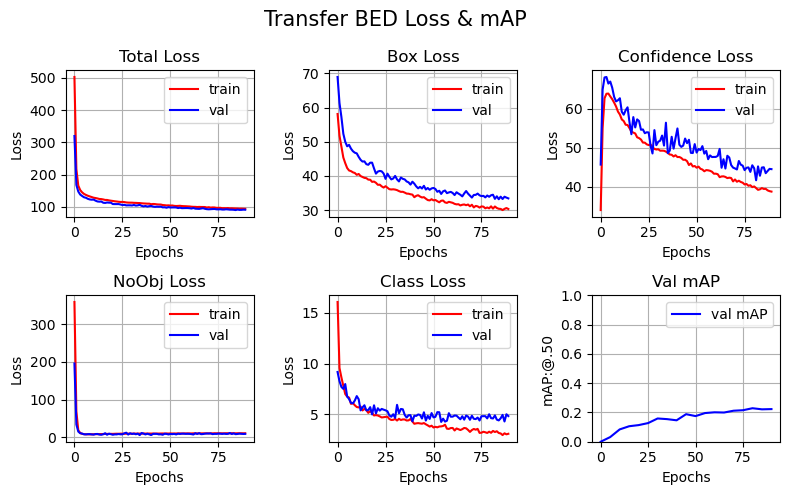

In [28]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(2,3, figsize=(8, 5))
fig.suptitle('Transfer BED Loss & mAP', fontsize=15)

plt.subplot(2,3,1)
plt.plot(train_total_loss, 'r', label="train")
plt.plot(val_total_loss, 'b', label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,2)
plt.plot(train_box_loss, 'r', label="train")
plt.plot(val_box_loss, 'b', label="val")
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,3)
plt.plot(train_confidence_loss, 'r', label="train")
plt.plot(val_confidence_loss, 'b', label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,4)
plt.plot(train_noobj_loss, 'r', label="train")
plt.plot(val_noobj_loss, 'b', label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,5)
plt.plot(train_class_loss, 'r', label="train")
plt.plot(val_class_loss, 'b', label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(2,3,6)
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, 'b', label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_loss_ma.png")
plt.show()

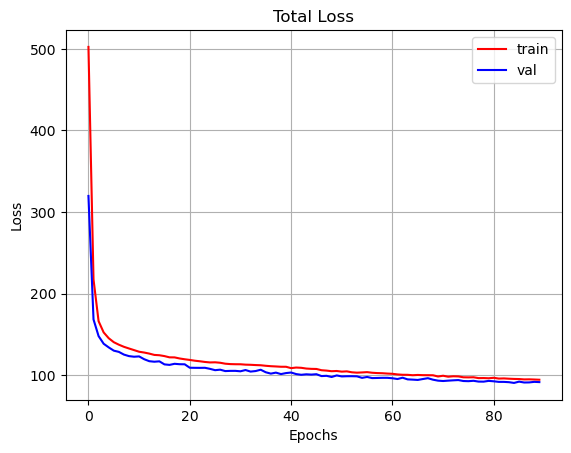

In [29]:
plt.plot(train_total_loss, 'r', label="train")
plt.plot(val_total_loss, 'b', label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_total.png")
plt.show()

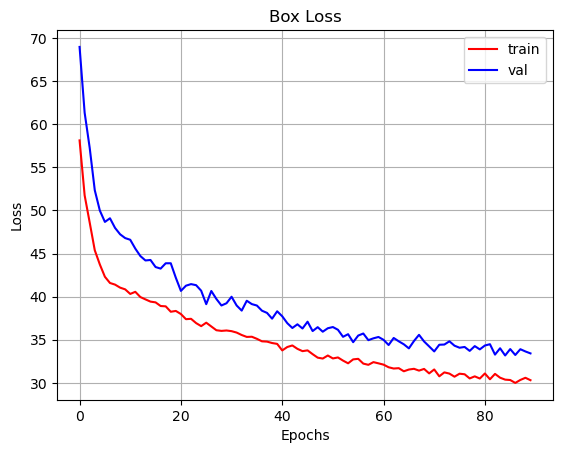

In [30]:
plt.plot(train_box_loss, 'r', label="train")
#plt.scatter(range(EPOCHS), train_box_loss)
plt.plot(val_box_loss, 'b', label="val")
#plt.scatter(range(EPOCHS), val_box_loss)
plt.title("Box Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_box.png")
plt.show()

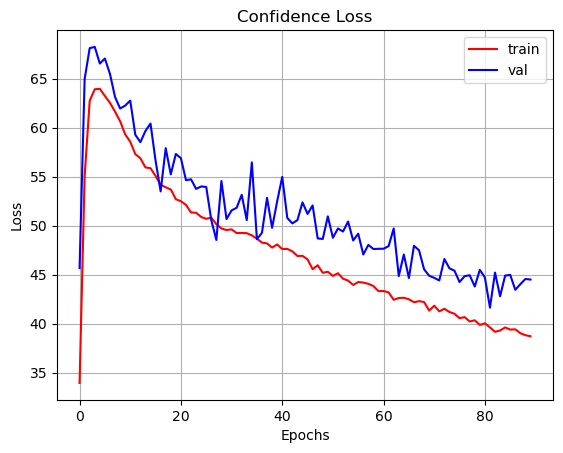

In [31]:
plt.plot(train_confidence_loss, 'r', label="train")
plt.plot(val_confidence_loss, 'b', label="val")
plt.title("Confidence Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_conf.png")
plt.show()

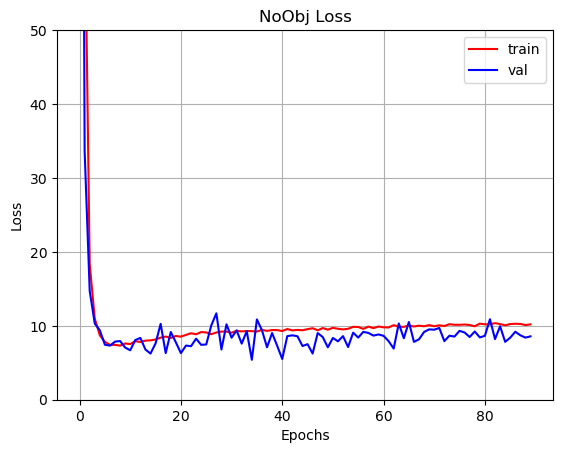

In [32]:
plt.plot(train_noobj_loss, 'r', label="train")
plt.plot(val_noobj_loss, 'b', label="val")
plt.title("NoObj Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim([0,50])
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_noobj.png")
plt.show()

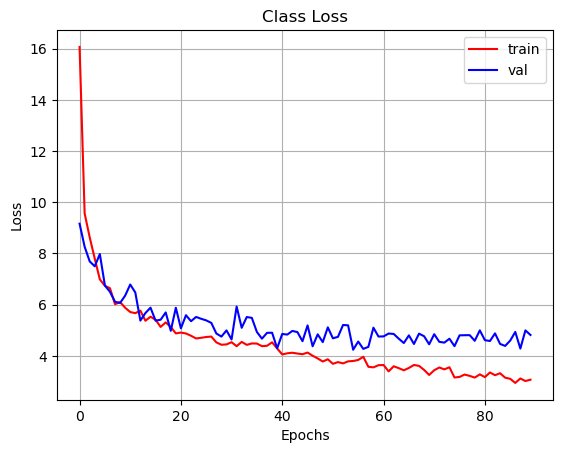

In [33]:
plt.plot(train_class_loss, 'r', label="train")
plt.plot(val_class_loss, 'b', label="val")
plt.title("Class Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.savefig(log_path + "bed_loss_class.png")
plt.show()

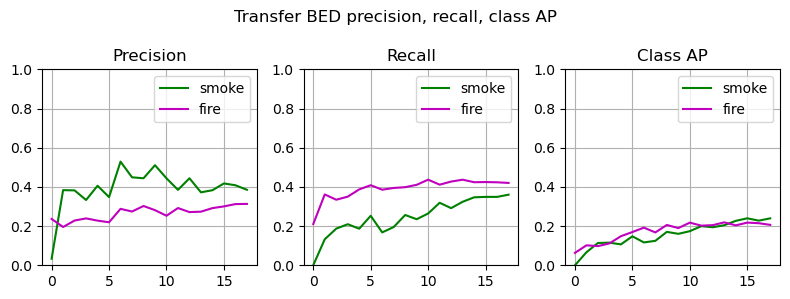

In [34]:
# val_class_AP
# val_class_precision
# val_class_recall

smoke_prec = []
fire_prec = []
for prec in val_class_precision:
    smoke_prec.append(prec[0])
    fire_prec.append(prec[1])

smoke_recall = []
fire_recall = []
for rec in val_class_recall:
    smoke_recall.append(rec[0])
    fire_recall.append(rec[1])

smoke_ap = []
fire_ap = []
for ap in val_class_AP:
    smoke_ap.append(ap[0])
    fire_ap.append(ap[1])

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
fig.suptitle('Transfer BED precision, recall, class AP')

plt.subplot(1, 3, 1)
plt.plot(smoke_prec, 'g', label="smoke")
plt.plot(fire_prec, 'm', label="fire")
plt.title("Precision")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(smoke_recall, 'g', label="smoke")
plt.plot(fire_recall, 'm', label="fire")
plt.title("Recall")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(smoke_ap, 'g', label="smoke")
plt.plot(fire_ap, 'm', label="fire")
plt.title("Class AP")
plt.ylim([0,1])
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig(log_path + "bed_precision_recall_classAP.png")
plt.show()

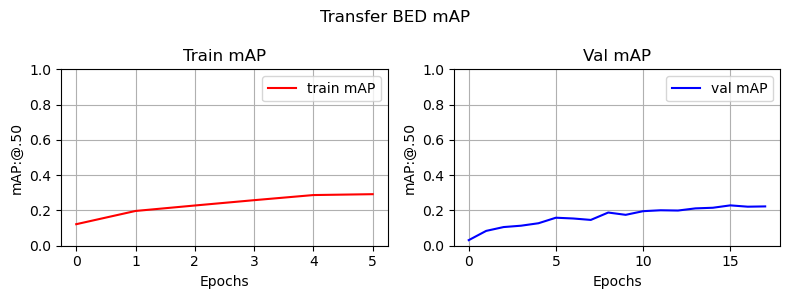

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
fig.suptitle('Transfer BED mAP')

plt.subplot(1,2,1)
plt.plot(train_mAP, 'r', label="train mAP")
plt.title("Train mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(val_mAP, 'b', label="val mAP")
plt.title("Val mAP")
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_mAP.png")
plt.show()

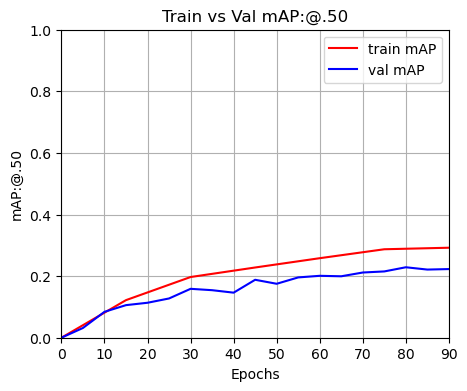

In [36]:
fig, axs = plt.subplots(figsize=(5, 4))

plt.plot(range(0, EPOCHS+1, 15), [0]+train_mAP, 'r', label="train mAP")
plt.plot(range(0, EPOCHS+1, 5), [0]+val_mAP, 'b', label="val mAP")
plt.title("Train vs Val mAP:@.50")
plt.xlim([0,EPOCHS])
plt.ylim([0,1])
plt.xlabel("Epochs")
plt.ylabel("mAP:@.50")
plt.legend()
plt.grid()

plt.savefig(log_path + "bed_mAP_together.png")
plt.show()